##### Отправляем сообщения всегда, но узел может быть не активен (блокирован) тогда сообщение ставится в очередь на узел
##### после блокировки узел считается снова свободным если очередь < L
##### число узлов 300, поток ренерируется 150 шагов, плотность сети 2,57
MultiplierThresholdToBlock <strong>L 100</strong>, FractionThresholdToUnBlock 1, UseOnlyIsActiveNodes True, NumberOfGenerations 150 <br>


In [1]:
from matplotlib import pyplot as plt
import numpy as np
from datetime import datetime
import pandas as pd
import os
from labellines import labelLine, labelLines
  
log_dir_path = os.path.abspath('..\\..\\')+"\\Result"
numberOfGenerations = 150;
percolation = 0.49;
nodeCount=300;

files = [
    {"filename": "Netsim-Node-Metrics-queue-{log_tag}", "title": "Среднее число сообщений в очереди на узле на обработку", "ylabel":"Число сообщений" },
    {"filename": "Netsim-Node-Metrics-load-{log_tag}", "title": "Загрузка узлов", "ylabel":"Доля от производительности узла" },
    {"filename": "Netsim-Connection-Metrics-load-{log_tag}", "title": "Средняя загрузка связей", "ylabel":"Доля от производительности связи" },
    {"filename": "Netsim-Message-Metrics-failed-{log_tag}", "title": "Число потерянных сообщений", "ylabel":"Число сообщений" },
]

filesBlocked = [
    {"filename": "Netsim-Node-Metrics-blocked-{log_tag}", "title": "Доля блокированных узлов" },
]
filesInfected = [
    {"filename": "Netsim-Node-Metrics-IsInfected-{log_tag}", "title": "Доля инфицированных узлов" },
]

filesMessage = [
    {"filename": "Netsim-Message-Metrics-{log_tag}", "title": "Число доставленных сообщений с течением времени" },

]
summBlocked = pd.DataFrame();
summInfected = pd.DataFrame();
MessageResived = pd.DataFrame();
MessageFall = pd.DataFrame();
MessageTimeSpent = pd.DataFrame();
          
def load_csv_file(path):
    file = open(path)
    data = file.readlines()
    splitted_data = [x.split(',') for x in data]
    return splitted_data, len(splitted_data[0])


def aggeregate_line(array):
    aggregated = [sum([float(y) for y in x])/len(x) for x in array]
    return aggregated, len(aggregated)


def showStat():
    for file in files:
        fig, ax = plt.subplots()
        plt.rcParams['figure.figsize'] = [10, 7]
        ax.set_title(file['title'])
        plt.axvline(x=numberOfGenerations, c="black")
        plt.xlabel("Шаги")
        plt.ylabel(file['ylabel'])
        
        for log_tag in log_tags:
            data, line_len = load_csv_file(f"{log_dir_path}/{file['filename'].format(log_tag = log_tag['tag'])}")
            aggregated, count = aggeregate_line(data)
            ax.plot(range(0, count), aggregated, c=log_tag['color'], label=log_tag['label'])    
            legend = ax.legend(loc='center left', bbox_to_anchor=(1, 0.5), shadow=True, fontsize='x-large')
            legend.get_frame()
    plt.show()
                                           
def get_xvals(lines):
    ax = lines[0].axes
    shrink_factor = 0.05
    xvals = ax.get_xlim()
    xvals_rng = xvals[1] - xvals[0]
    shrinkage = xvals_rng * shrink_factor
    xvals = (xvals[0] + shrinkage, xvals[1] - shrinkage)
    return xvals;
                                           
def get_x(xvals, i, count):
    h = (xvals[1] - xvals[0])/(count+1);
    return h*(i+1)+xvals[0];
                                           
                                           
def aggeregate_line_perc_node(array):
    aggregated = [sum([1 for y in x if float(y) > 0])/len(x) for x in array]
    return aggregated, len(aggregated)

def showStatInfected():
    for file in filesInfected:
        fig, ax = plt.subplots()
        plt.rcParams['figure.figsize'] = [10, 7]
        ax.set_title(file['title'])
        plt.axvline(x=numberOfGenerations, c="black")
        plt.axhline(y=percolation, color='r', linestyle='-')
        plt.xlabel("Шаги")
        plt.ylabel("Доля инфицированных узлов")

        for log_tag in log_tags:
            data, line_len = load_csv_file(f"{log_dir_path}/{file['filename'].format(log_tag = log_tag['tag'])}")
            aggregated, count = aggeregate_line_perc_node(data)
            summ = np.sum(aggregated)
            summInfected.at[quantity, log_tag['label']] = summ/count;
            ax.plot(range(0, count), aggregated, c=log_tag['color'], label=log_tag['label']+' S='+str(summ))    
            legend = ax.legend(loc='center left', bbox_to_anchor=(1, 0.5), shadow=True, fontsize='x-large')
            legend.get_frame()

def showStatBlocked():
    for file in filesBlocked:
        fig, ax = plt.subplots()
        plt.rcParams['figure.figsize'] = [10, 7]
        ax.set_title(file['title'])
        plt.axvline(x=numberOfGenerations, c="black")
        plt.axhline(y=percolation, color='r', linestyle='-')
        plt.xlabel("Шаги")
        plt.ylabel("Доля блокированных узлов")

        for log_tag in log_tags:
            data, line_len = load_csv_file(f"{log_dir_path}/{file['filename'].format(log_tag = log_tag['tag'])}")
            dataI, line_lenI = load_csv_file(f"{log_dir_path}/{filesInfected[0]['filename'].format(log_tag = log_tag['tag'])}")
                                           
            aggregated, count = aggeregate_line_perc_node(data)
            aggregatedI, count = aggeregate_line_perc_node(dataI)
            aggregated = np.array(aggregated) - np.array(aggregatedI)
            summ = np.sum(aggregated)
            summBlocked.at[quantity, log_tag['label']] = summ/count;
            ax.plot(range(0, count), aggregated, c=log_tag['color'], label=log_tag['label']+' S='+str(summ))    
            legend = ax.legend(loc='center left', bbox_to_anchor=(1, 0.5), shadow=True, fontsize='x-large')
            legend.get_frame()
    showStatInfected();

def str2bool(v):
    return v.lower() in ("yes", "true", "t", "1")

def load_csv_file_message(path):
    file = open(path)
    data = file.readlines()
    t = datetime(2021,6,1,1)
   
    splitted_data = [(str2bool(x.split(',')[-2]), (datetime.strptime(x.split(',')[-1], '%d.%m.%Y %H:%M:%S\n')-t).total_seconds(), float(x.split(',')[2]))  for x in data]
    df = pd.DataFrame(data=splitted_data,  columns=['Resived', 'Time' ,'TimeSpent']);
    total_count = len(df.index);
    timeSpent_avr = df['TimeSpent'].mean();
    df = df.loc[df['Resived'] == True]
    agg= df.groupby(['Time']).count()
    return agg['Resived'].to_numpy(), agg.index.get_level_values(0).to_numpy(), total_count, timeSpent_avr

def showStatMessage():
    for file in filesMessage:
        fig, ax = plt.subplots()
        plt.rcParams['figure.figsize'] = [10, 7]
        ax.set_title(file['title'])
        plt.axvline(x=numberOfGenerations, c="black")
        plt.xlabel("Шаги")
        plt.ylabel("Число сообщений")
       
        for log_tag in log_tags:
            data, line_len, all_count, timeSpent_avr = load_csv_file_message(f"{log_dir_path}/{file['filename'].format(log_tag = log_tag['tag'])}")
            summ = np.sum(data);
            fall = (all_count-summ)*100/all_count;
            print('Доставлено '+str(summ)+' Потеряно '+ "{:3.4f}".format(fall)+'% -'+log_tag['label']);
            
            MessageResived.at[quantity, log_tag['label']] = summ*100/all_count;
            MessageFall.at[quantity, log_tag['label']] = fall;
            MessageTimeSpent.at[quantity, log_tag['label']] = timeSpent_avr;
            ax.plot(line_len, data, c=log_tag['color'], label=log_tag['label']+' S='+str(summ))    
            legend = ax.legend(loc='center left', bbox_to_anchor=(1, 0.5), shadow=True, fontsize='x-large')
            legend.get_frame()
    plt.show()


<strong>Поток Quantity 100 </strong>

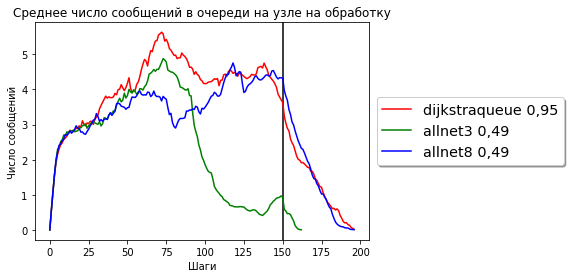

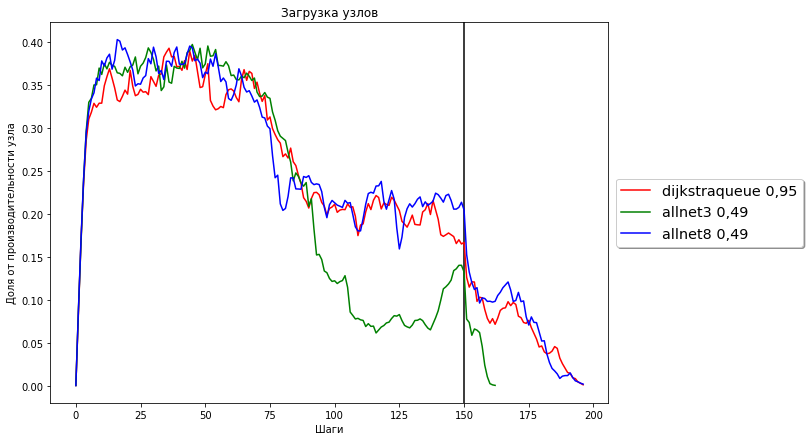

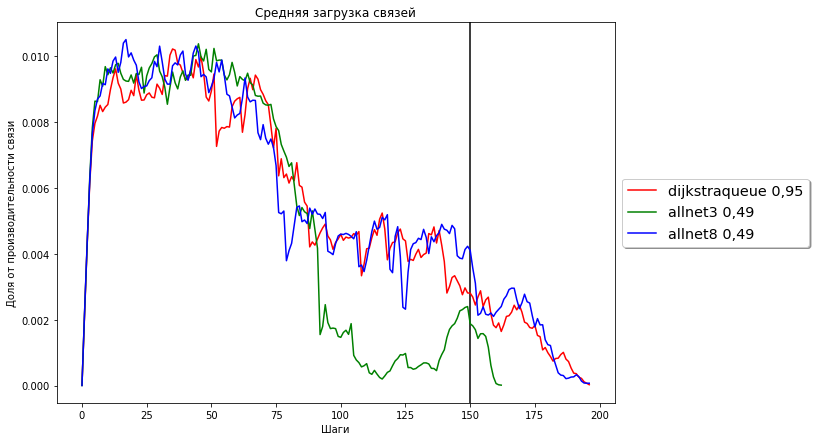

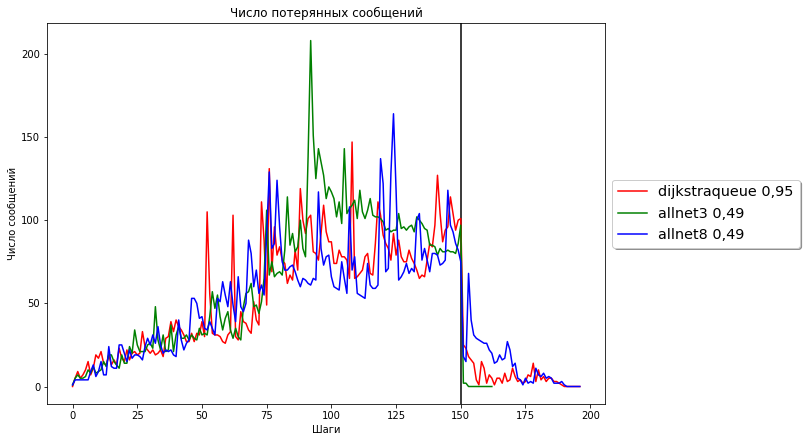

Доставлено 6102 Потеряно 59.3227% -dijkstraqueue 0,95
Доставлено 5327 Потеряно 64.4890% -allnet3 0,49
Доставлено 6083 Потеряно 59.4494% -allnet8 0,49


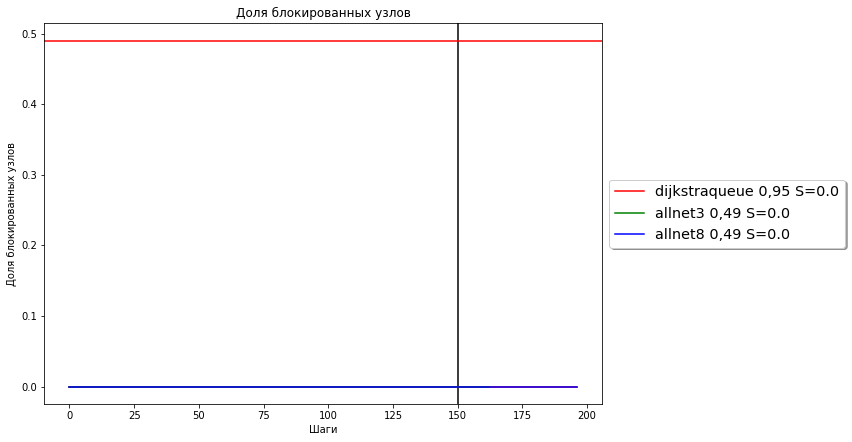

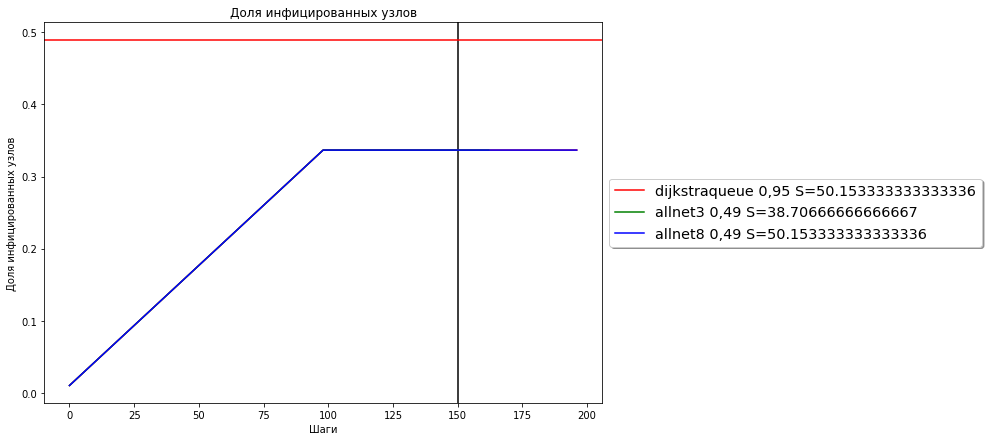

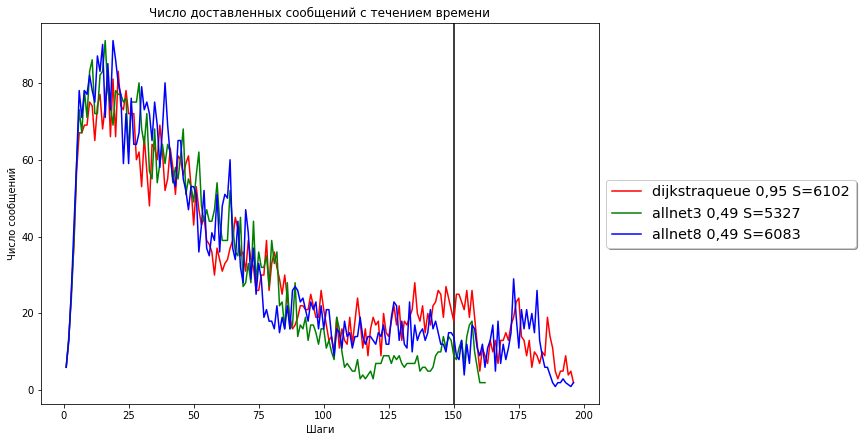

In [2]:
quantity = 100;
log_tags = [
{"tag":  "b6f3314f-ef1c-49ce-bff4-431dce4a2f1c", "label": "dijkstraqueue 0,95", "color": "red"},
{"tag":  "5b18d93a-0f74-44fb-bc09-b12a6da9b1a7", "label": "allnet3 0,49", "color": "green"},
{"tag":  "3320a07d-b1a5-47ff-b5ad-f38769bf3c0d", "label": "allnet8 0,49", "color": "blue"},
]
                             
showStat()
showStatBlocked();  
showStatMessage(); 

<strong>Quantity 500 </strong>

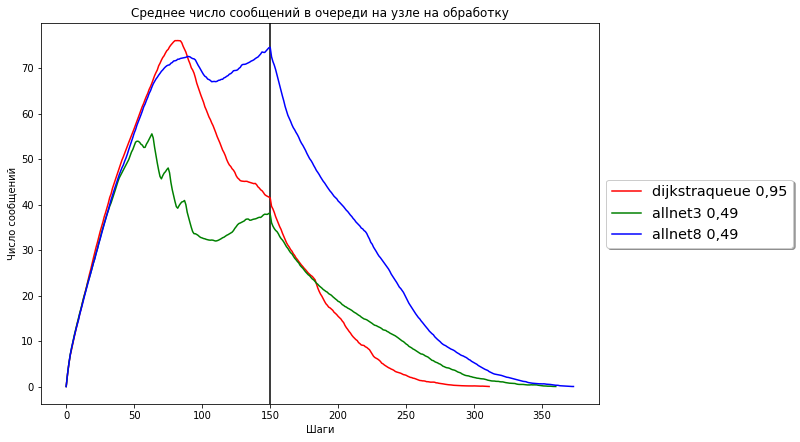

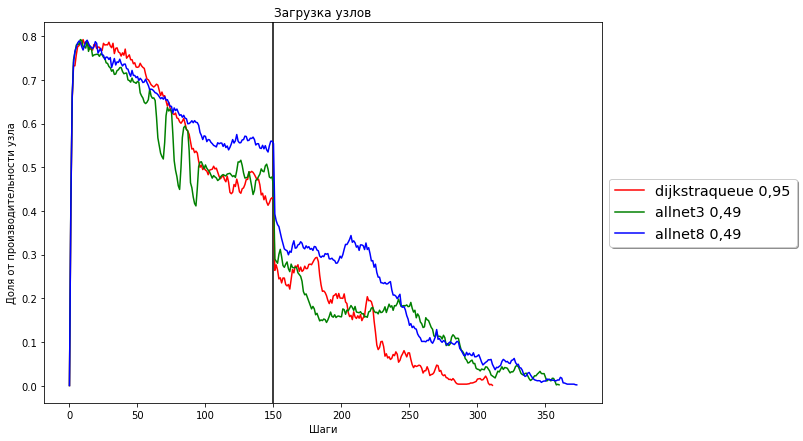

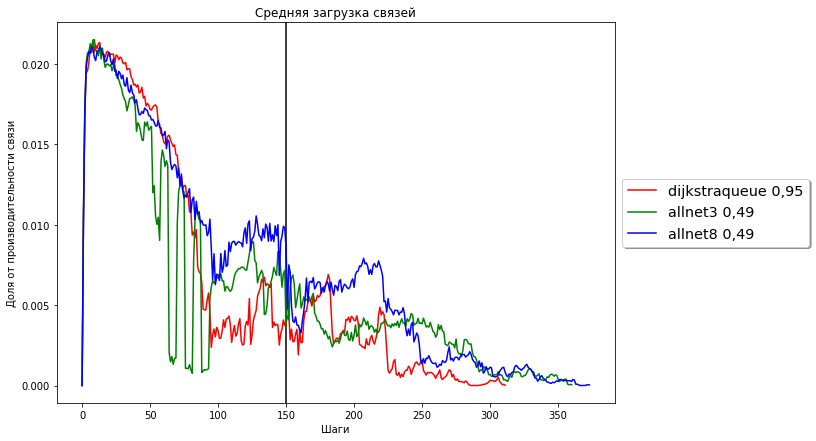

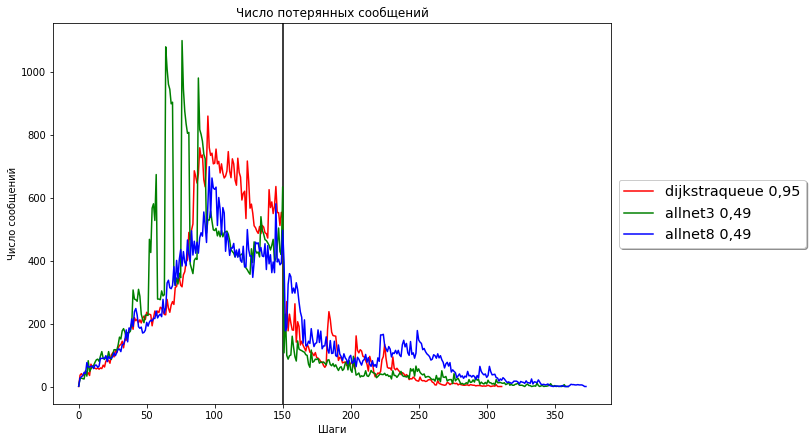

Доставлено 7042 Потеряно 90.6108% -dijkstraqueue 0,95
Доставлено 8782 Потеряно 88.2908% -allnet3 0,49
Доставлено 9695 Потеряно 87.0735% -allnet8 0,49


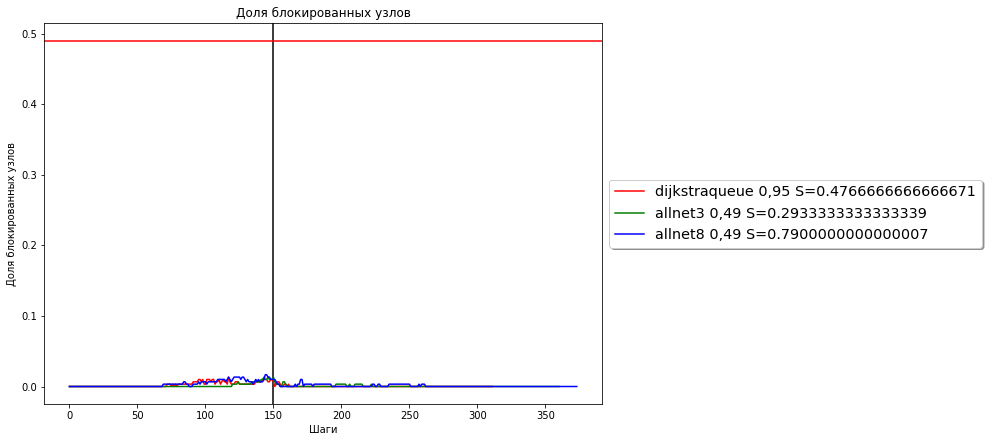

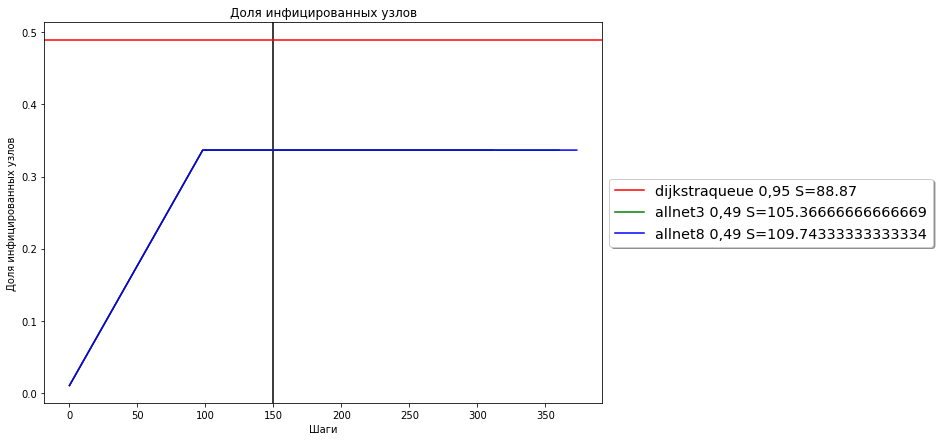

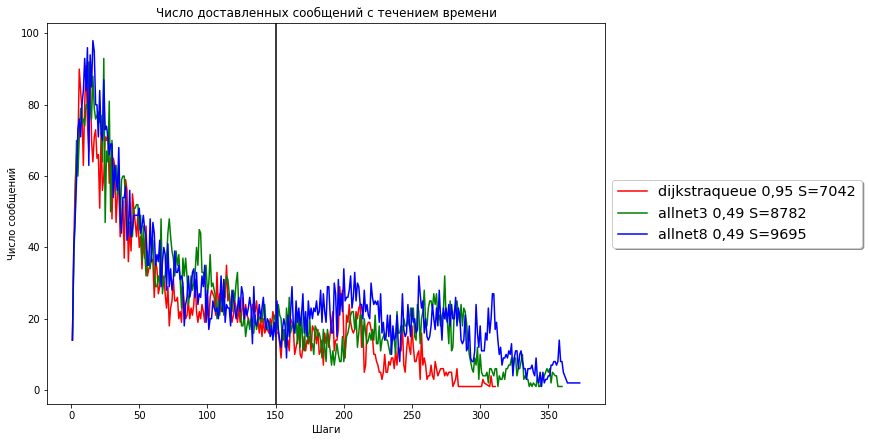

In [3]:
quantity = 500;
log_tags = [
{"tag":  "3eccdffa-e296-4fdb-a504-45749b349ed3", "label": "dijkstraqueue 0,95", "color": "red"},
{"tag":  "985cc477-3e2e-4d11-8752-ff6bc9090c0f", "label": "allnet3 0,49", "color": "green"},
{"tag":  "38eea856-0455-49c6-bd7f-46ae5b23c06f", "label": "allnet8 0,49", "color": "blue"},
]
showStat()
showStatBlocked();  
showStatMessage(); 

<strong>Quantity 1000 </strong>

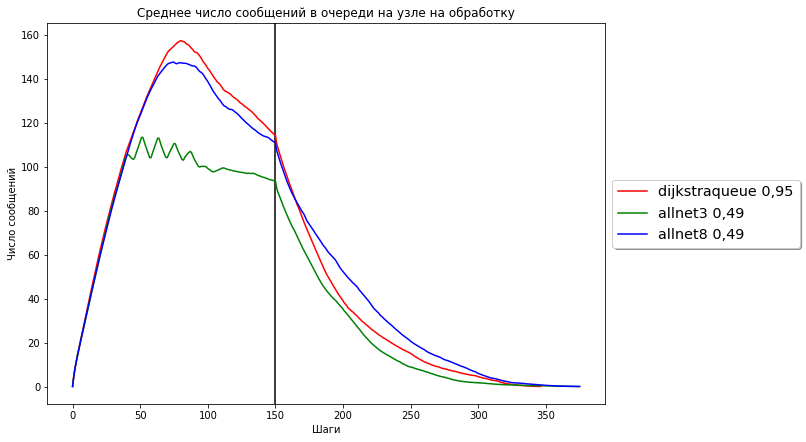

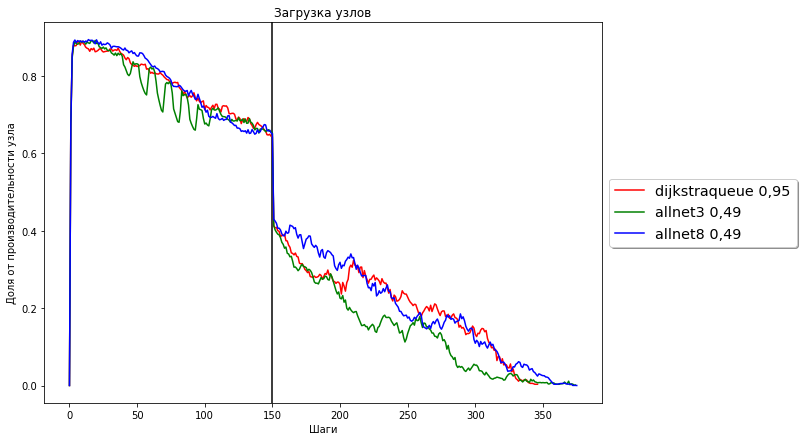

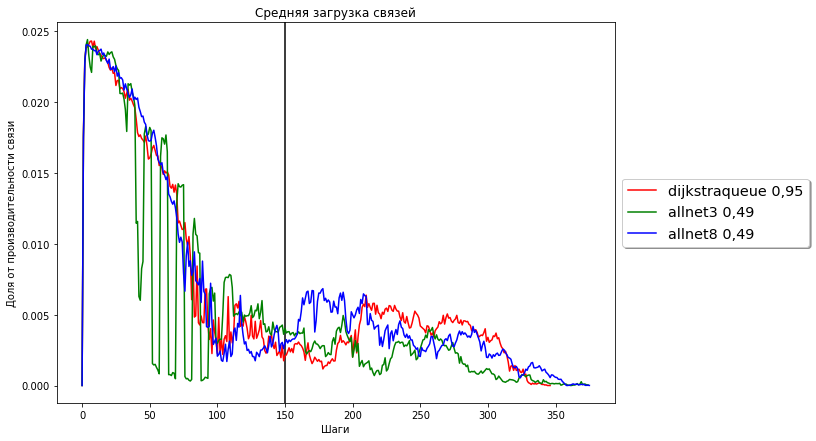

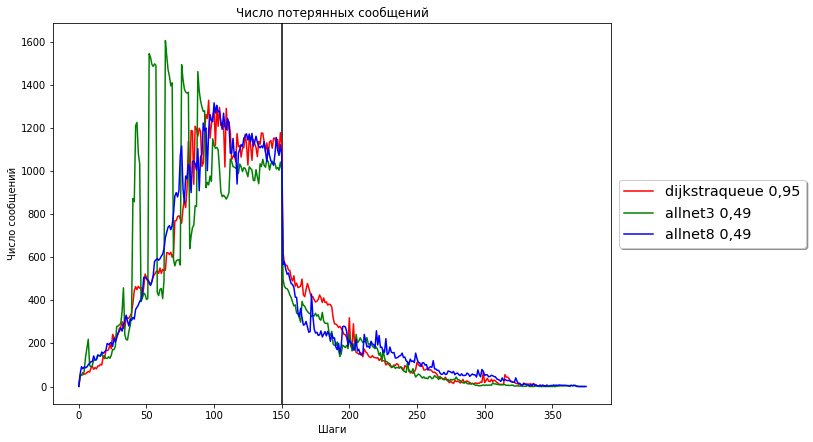

Доставлено 9921 Потеряно 93.3860% -dijkstraqueue 0,95
Доставлено 8227 Потеряно 94.5154% -allnet3 0,49
Доставлено 9095 Потеряно 93.9367% -allnet8 0,49


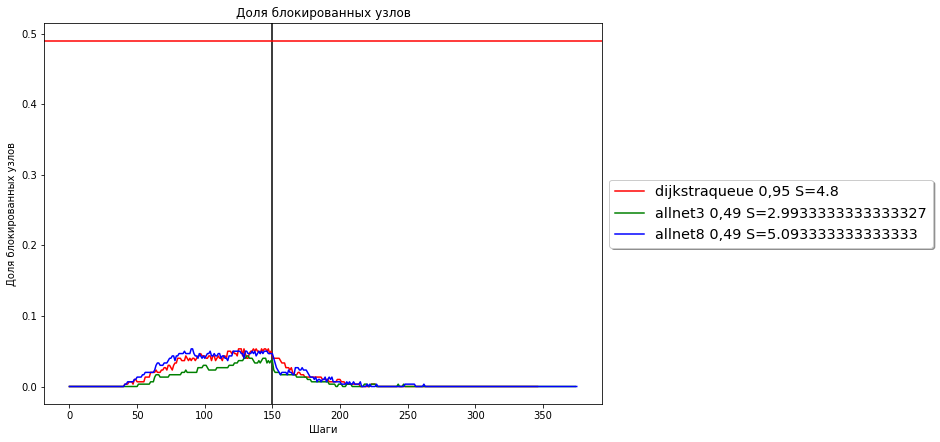

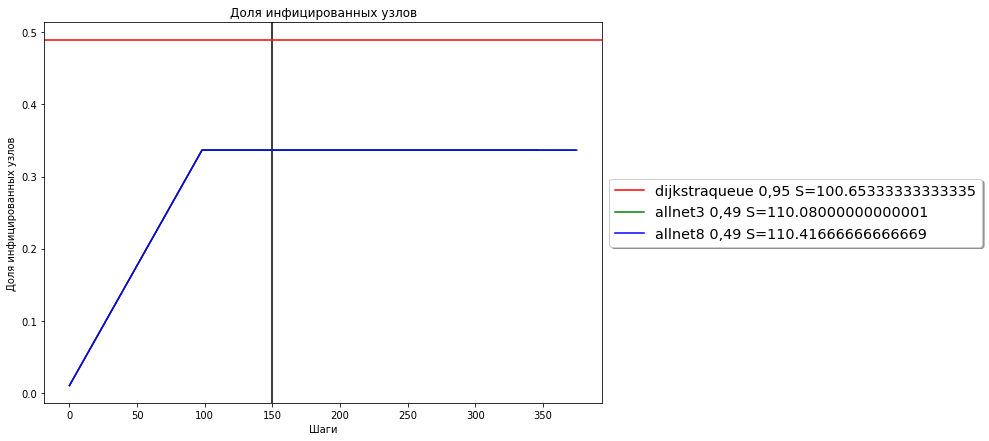

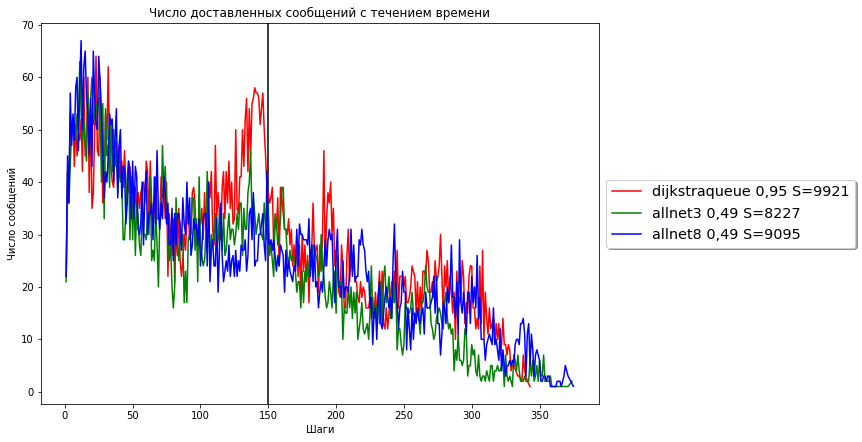

In [4]:
quantity = 1000;
log_tags = [
{"tag":  "a1f1643a-ce9c-4572-94be-143938b5f8b5", "label": "dijkstraqueue 0,95", "color": "red"},
{"tag":  "756efd12-178d-4aa0-9309-996c8611e569", "label": "allnet3 0,49", "color": "green"},
{"tag":  "7dd28c32-61cb-451b-8812-294927ce5fc3", "label": "allnet8 0,49", "color": "blue"},
]
showStat()
showStatBlocked();  
showStatMessage();

<strong>Quantity 1500 </strong>

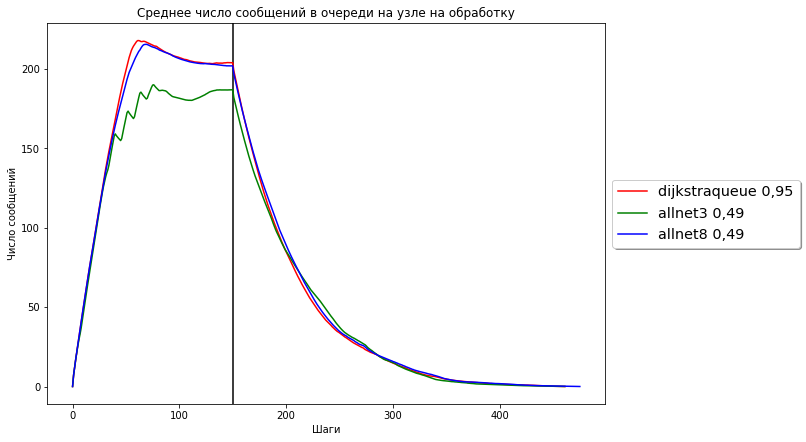

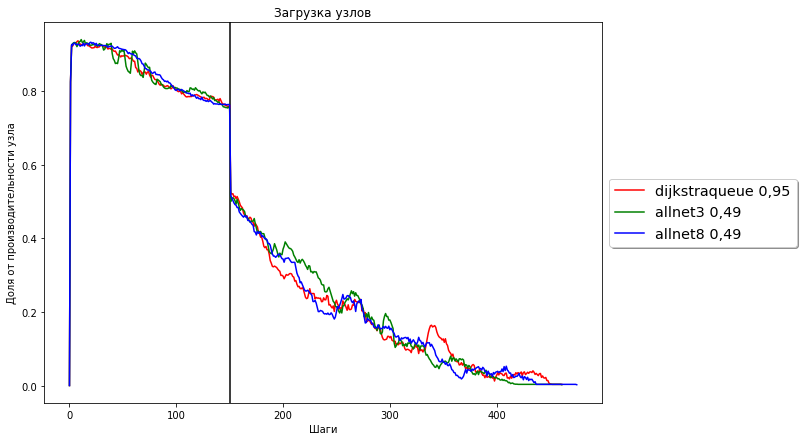

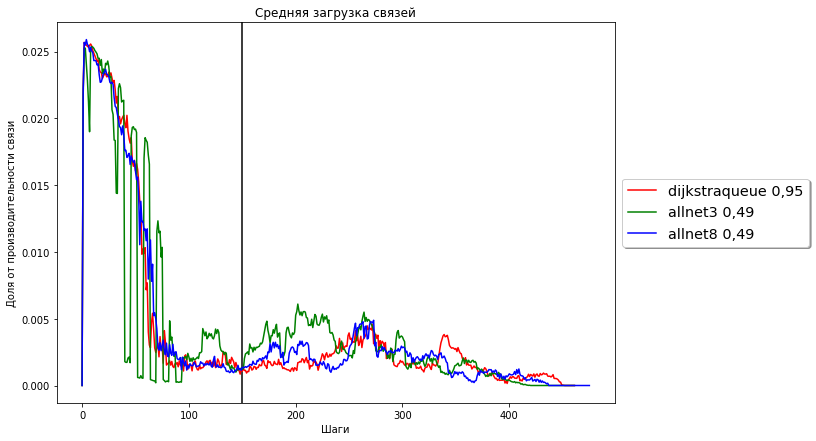

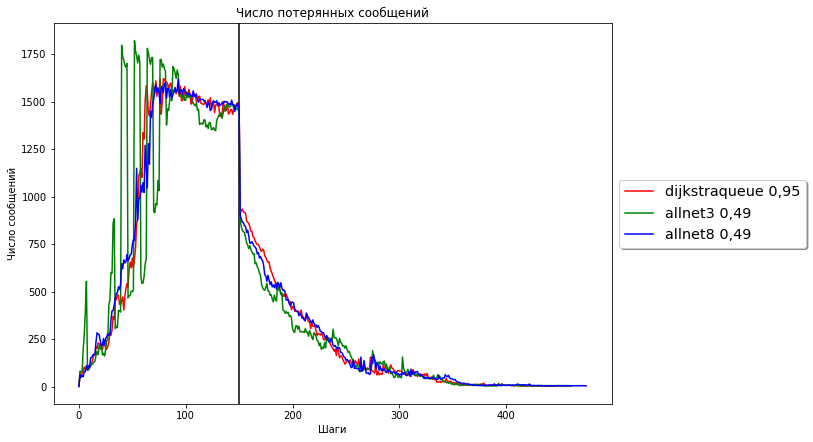

Доставлено 9123 Потеряно 95.9454% -dijkstraqueue 0,95
Доставлено 9166 Потеряно 95.9262% -allnet3 0,49
Доставлено 8989 Потеряно 96.0049% -allnet8 0,49


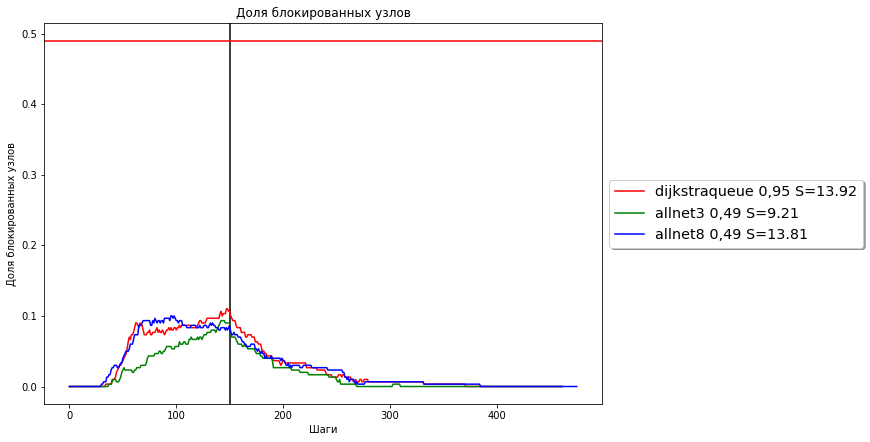

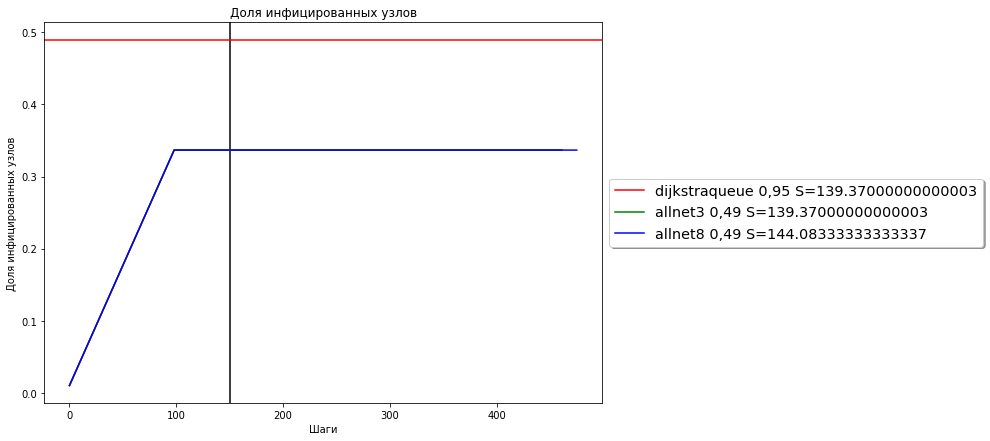

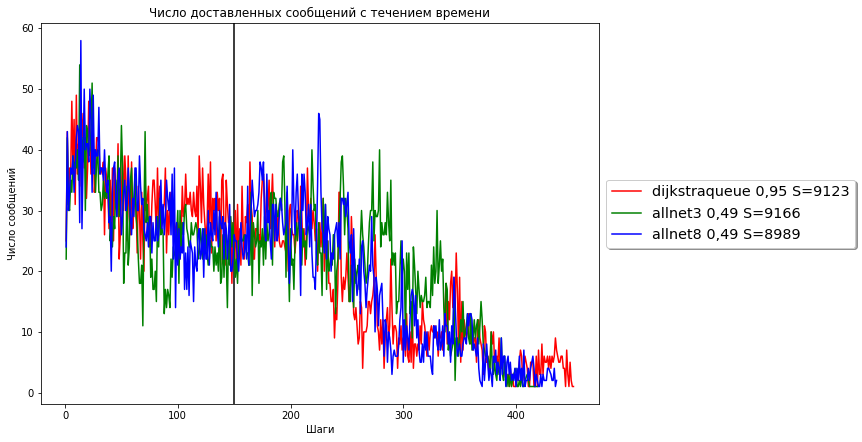

In [5]:
quantity = 1500;
log_tags = [
{"tag":  "fd4beb72-9daa-455d-800b-05293f44c9fa", "label": "dijkstraqueue 0,95", "color": "red"},
{"tag":  "0899606e-1df4-48c8-a66f-66a36a1977ba", "label": "allnet3 0,49", "color": "green"},
{"tag":  "cbfdf895-3b6e-4978-8631-e0cb57e8585a", "label": "allnet8 0,49", "color": "blue"},
]

showStat()
showStatBlocked();  
showStatMessage();

Доставлено 8599 Потеряно 80.8915% -dijkstraqueue 0,95
Доставлено 9295 Потеряно 79.3449% -allnet3 0,49
Доставлено 8211 Потеряно 81.7537% -allnet8 0,49


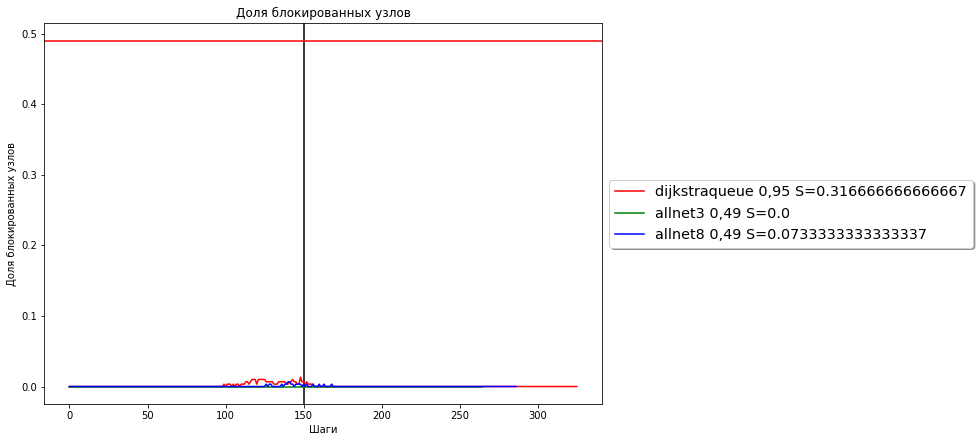

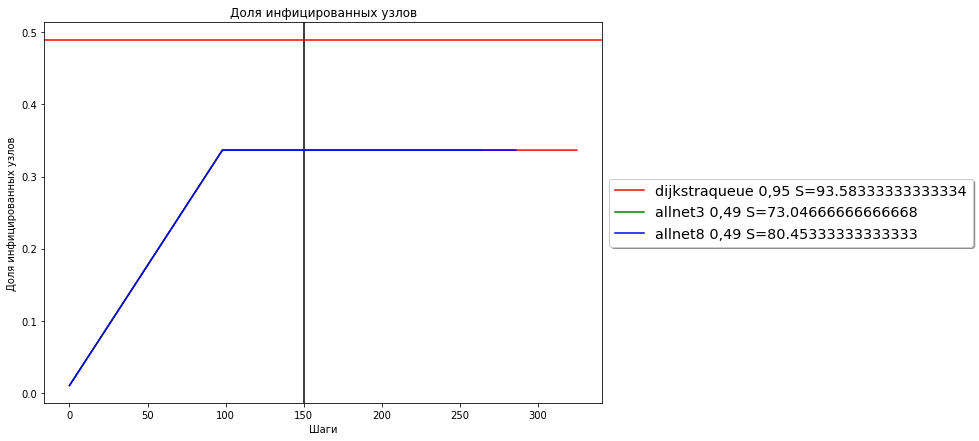

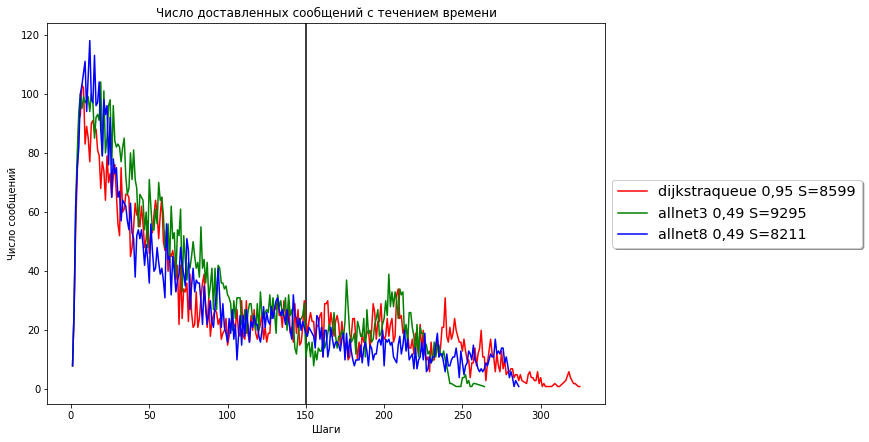

Доставлено 9854 Потеряно 90.6153% -dijkstraqueue 0,95
Доставлено 8123 Потеряно 92.2639% -allnet3 0,49
Доставлено 9909 Потеряно 90.5629% -allnet8 0,49


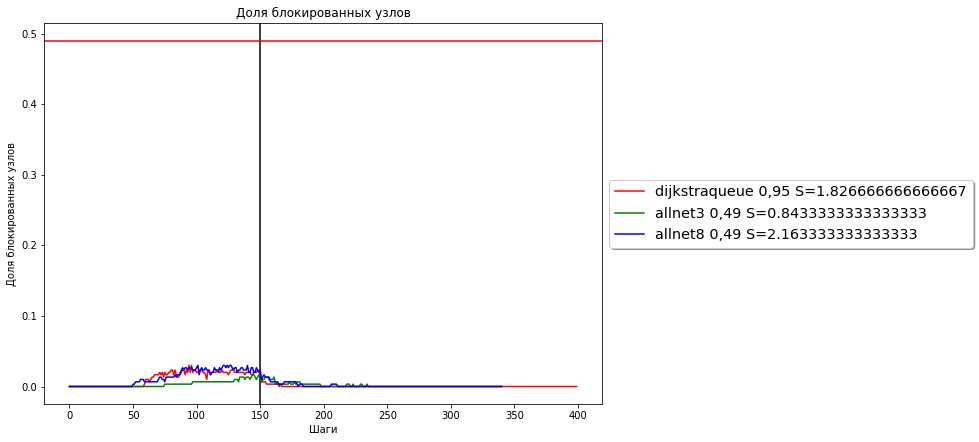

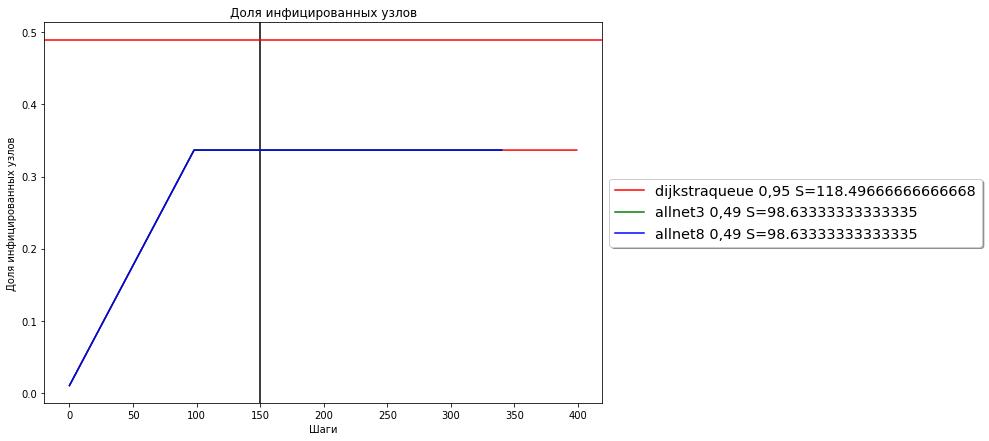

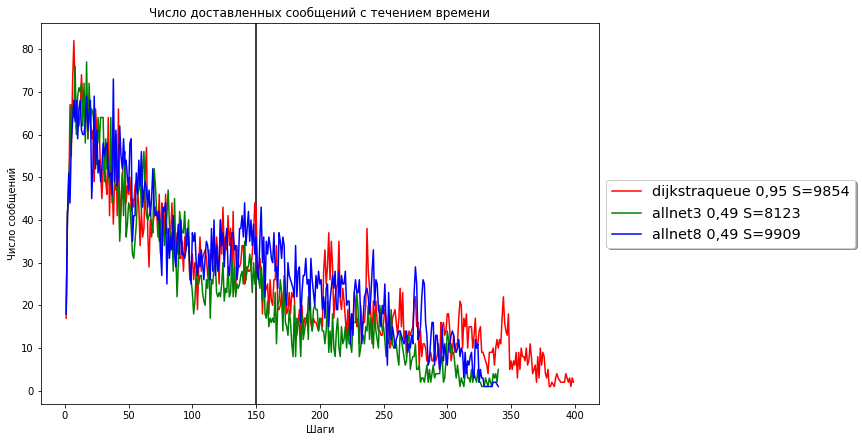

Доставлено 8600 Потеряно 93.6297% -dijkstraqueue 0,95
Доставлено 7923 Потеряно 94.1312% -allnet3 0,49
Доставлено 9566 Потеряно 92.9141% -allnet8 0,49


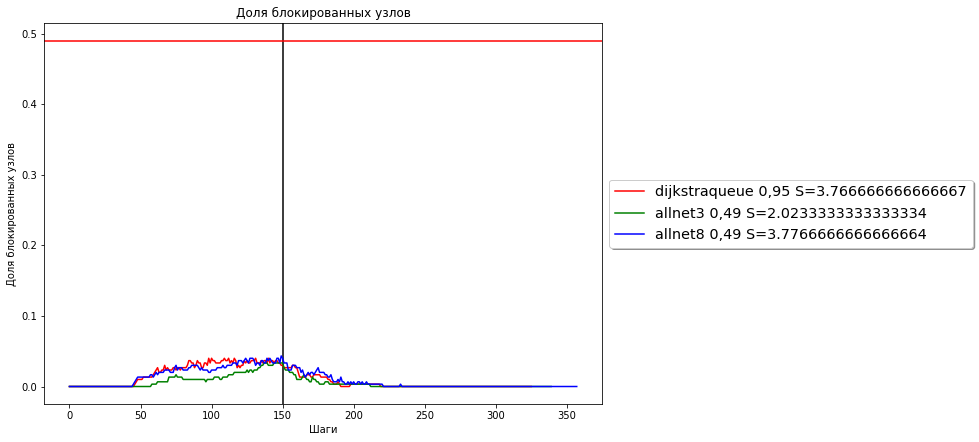

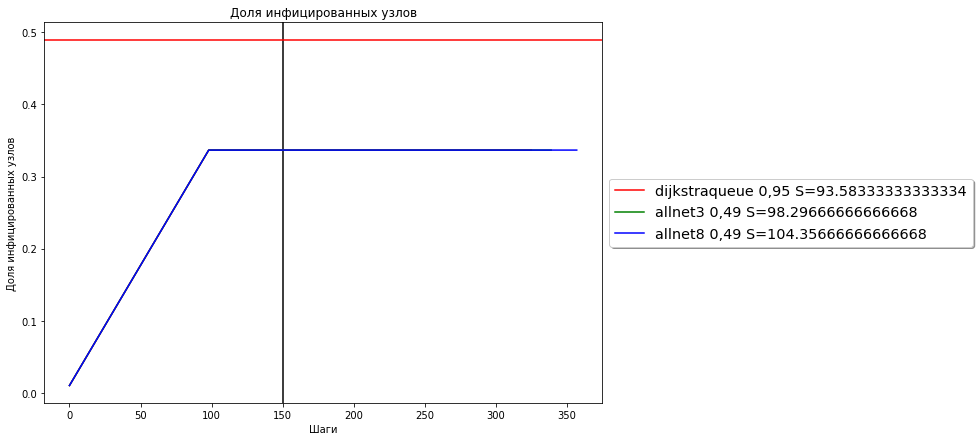

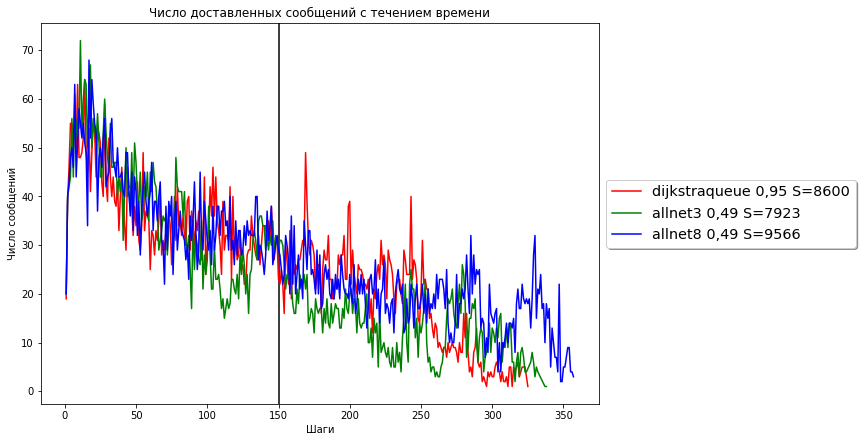

Доставлено 9358 Потеряно 95.2011% -dijkstraqueue 0,95
Доставлено 9150 Потеряно 95.3077% -allnet3 0,49
Доставлено 9154 Потеряно 95.3057% -allnet8 0,49


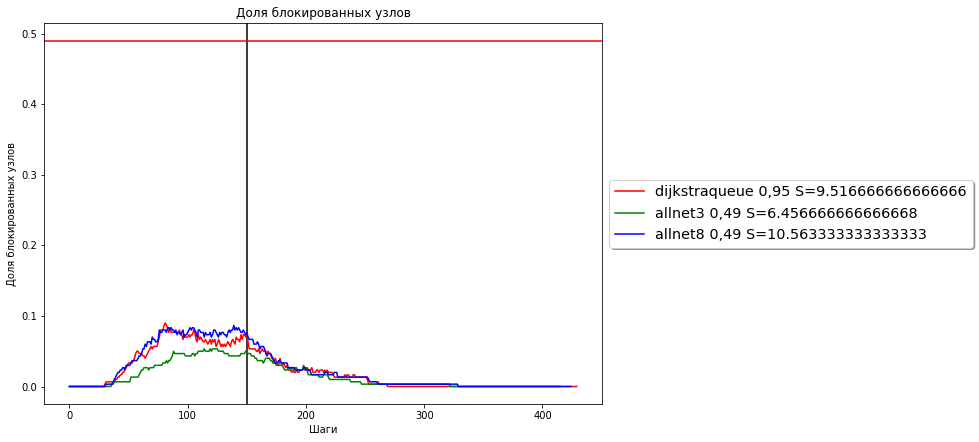

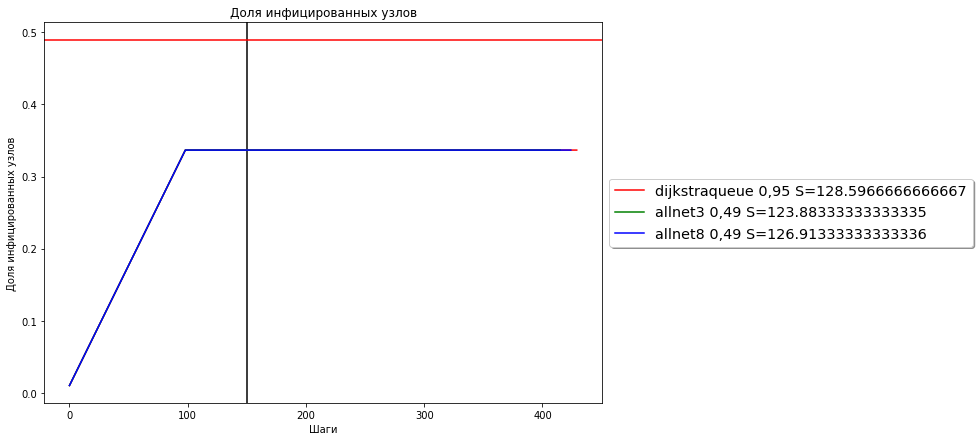

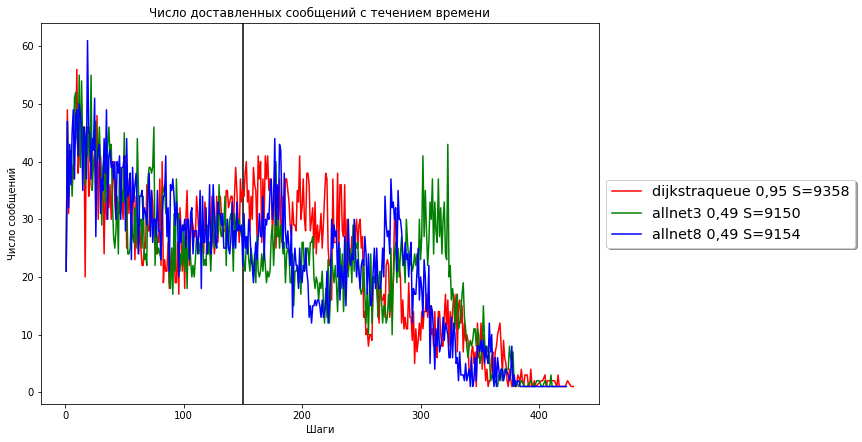

In [6]:

quantity = 300;
log_tags = [
{"tag":  "1aa835f1-8cf7-40c1-966f-ab23cda1c86b", "label": "dijkstraqueue 0,95", "color": "red"},
{"tag":  "c8e3ed51-a422-45ca-b0f5-be061eed3d1d", "label": "allnet3 0,49", "color": "green"},
{"tag":  "731baa2a-f65c-49f2-ac49-fab859b00b03", "label": "allnet8 0,49", "color": "blue"},
]
showStatBlocked();
showStatMessage();

quantity = 700;
log_tags = [
{"tag":  "134392f5-b7e6-4d89-8210-eacc115b74ca", "label": "dijkstraqueue 0,95", "color": "red"},
{"tag":  "dfa872fb-ce41-4beb-b166-56114c43f59d", "label": "allnet3 0,49", "color": "green"},
{"tag":  "0317edbc-9c01-4a05-911a-4a0a9c0def87", "label": "allnet8 0,49", "color": "blue"},
]
showStatBlocked();
showStatMessage();

quantity = 900;
log_tags = [
{"tag":  "7b76f65c-f6bc-48d2-a432-b307c28a9677", "label": "dijkstraqueue 0,95", "color": "red"},
{"tag":  "76b0dccf-7159-4ada-a772-94cd75e2257c", "label": "allnet3 0,49", "color": "green"},
{"tag":  "e4c7ee7e-da72-4e99-9579-ea9781926076", "label": "allnet8 0,49", "color": "blue"},
]
showStatBlocked();
showStatMessage();

quantity = 1300;
log_tags = [
{"tag":  "a6229427-343f-45c2-a916-73812c7a7d23", "label": "dijkstraqueue 0,95", "color": "red"},
{"tag":  "5bc4552f-2260-4ec6-a85f-275b38b77010", "label": "allnet3 0,49", "color": "green"},
{"tag":  "2795ca95-831c-4a54-a91d-90fbd128d883", "label": "allnet8 0,49", "color": "blue"},

]
showStatBlocked();  
showStatMessage();

      dijkstraqueue 0,95  allnet3 0,49  allnet8 0,49
100            10.922605      5.895874      9.574228
300            35.398991     21.904247     31.727317
500            36.149518     30.449207     52.209491
700            39.166475     28.065695     42.015752
900            44.579611     33.029666     45.654469
1000           44.702795     34.967834     45.389531
1300           52.953805     38.052995     47.407198
1500           49.921396     45.811912     50.008520


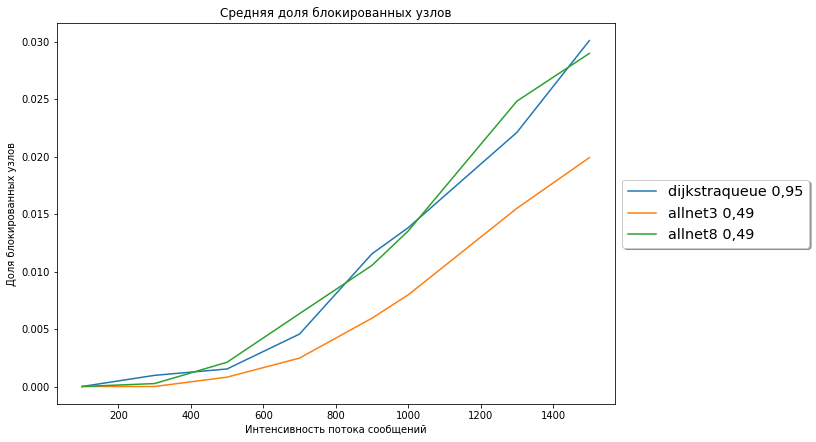

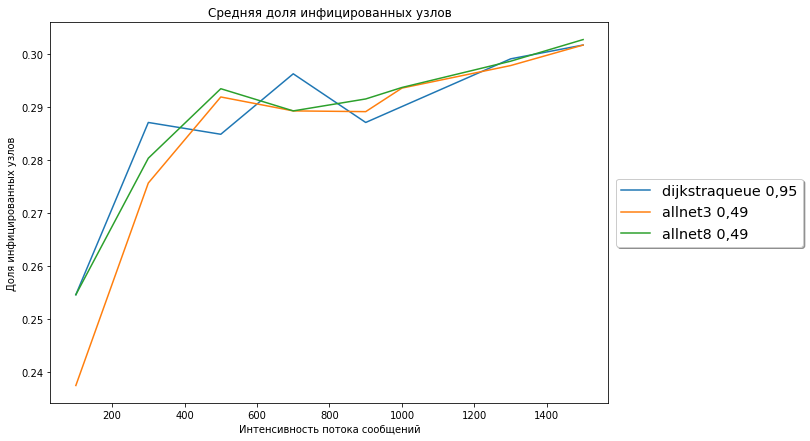

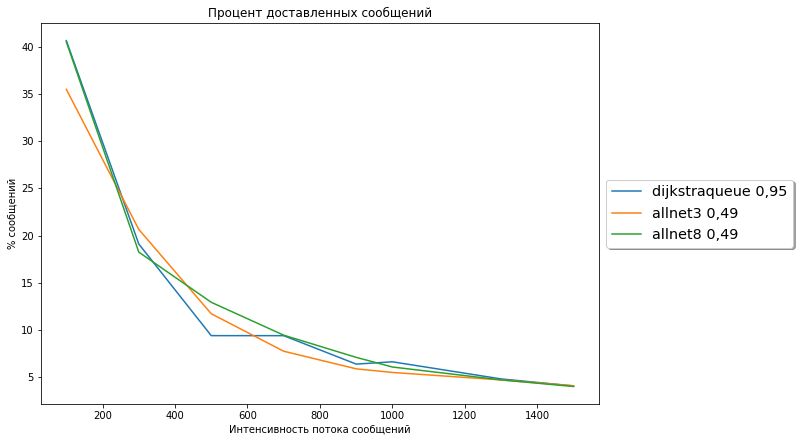

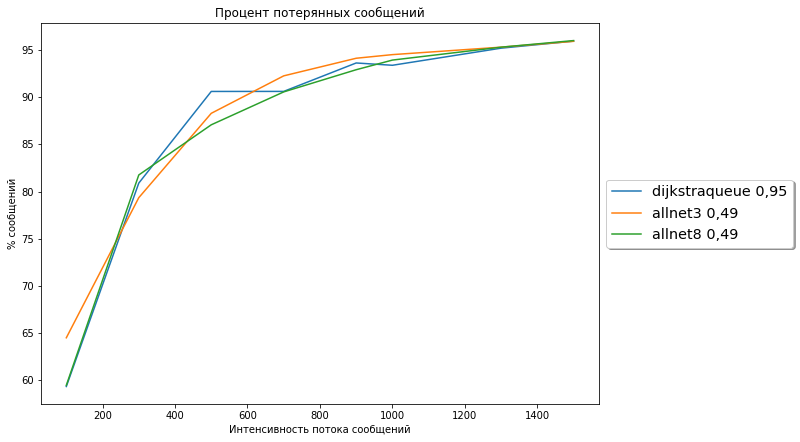

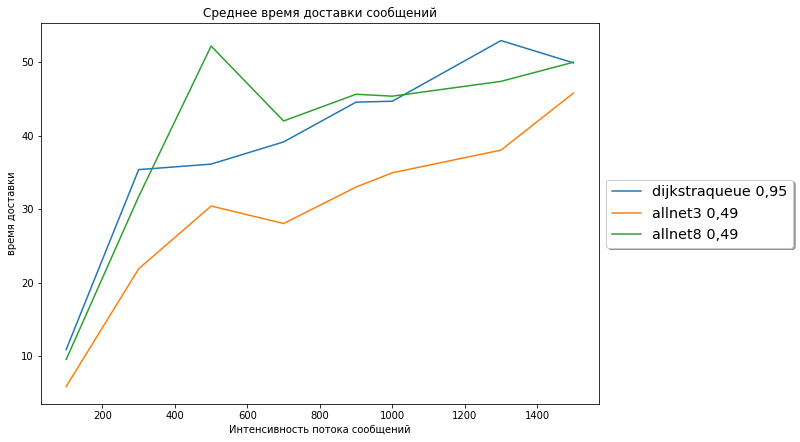

In [7]:
summBlocked.sort_index(inplace=True)
axs = summBlocked.plot()
axs.set_title("Средняя доля блокированных узлов")
axs.set_xlabel("Интенсивность потока сообщений")
axs.set_ylabel("Доля блокированных узлов")
legend = axs.legend(loc='center left', bbox_to_anchor=(1, 0.5), shadow=True, fontsize='x-large')
legend.get_frame()

summInfected.sort_index(inplace=True)
axs = summInfected.plot()
axs.set_title("Средняя доля инфицированных узлов")
axs.set_xlabel("Интенсивность потока сообщений")
axs.set_ylabel("Доля инфицированных узлов")
legend = axs.legend(loc='center left', bbox_to_anchor=(1, 0.5), shadow=True, fontsize='x-large')
legend.get_frame()

MessageResived.sort_index(inplace=True)
axs = MessageResived.plot()
axs.set_title("Процент доставленных сообщений")
axs.set_xlabel("Интенсивность потока сообщений")
axs.set_ylabel("% сообщений")
legend = axs.legend(loc='center left', bbox_to_anchor=(1, 0.5), shadow=True, fontsize='x-large')
legend.get_frame()

MessageFall.sort_index(inplace=True)
axs = MessageFall.plot()
axs.set_title("Процент потерянных сообщений")
axs.set_xlabel("Интенсивность потока сообщений")
axs.set_ylabel("% сообщений")
legend = axs.legend(loc='center left', bbox_to_anchor=(1, 0.5), shadow=True, fontsize='x-large')
legend.get_frame()

MessageTimeSpent.sort_index(inplace=True)
axs = MessageTimeSpent.plot()
axs.set_title("Среднее время доставки сообщений")
axs.set_xlabel("Интенсивность потока сообщений")
axs.set_ylabel("время доставки")
legend = axs.legend(loc='center left', bbox_to_anchor=(1, 0.5), shadow=True, fontsize='x-large')
legend.get_frame()
print (MessageTimeSpent)

In [8]:
print(summBlocked.mean().to_string())
print("")
print(MessageFall.mean().to_string())
print("")
print(MessageTimeSpent.mean().to_string())
print("")
print(summInfected.mean().to_string())

dijkstraqueue 0,95    0.010589
allnet3 0,49          0.006584
allnet8 0,49          0.010834

dijkstraqueue 0,95    87.450311
allnet3 0,49          88.033641
allnet8 0,49          87.125121

dijkstraqueue 0,95    39.224400
allnet3 0,49          29.772179
allnet8 0,49          40.498313

dijkstraqueue 0,95    0.287574
allnet3 0,49          0.284544
allnet8 0,49          0.288008
